# Analysis

In [18]:
import pandas as pd
import plotnine as pn


In [19]:
# Load data

# Pareto frontier
curve_fn = "/Users/nathanielimel/lps/projects/rdsg/outputs/states=10/signals=10/similarity=nosofsky/distortion=squared_dist/curve_points.csv"

# Explored hypothetical systems
sampled_fn = "/Users/nathanielimel/lps/projects/rdsg/outputs/states=10/signals=10/similarity=nosofsky/distortion=squared_dist/sampled_points.csv"

# simulation points
alphas = [0, 2, 4, 6, 8, 10]

# Learned
dynamic = "reinforcement_learning"
dynamic = "replicator_dynamic"
num_trials = 10
num_trials = 100

alpha_fns = {
    f"{alpha}":f"/Users/nathanielimel/lps/projects/rdsg/multirun/states=10/signals=10/similarity=nosofsky/distortion=squared_dist/dynamics={dynamic}/num_trials={num_trials}/sim_param={alpha}/simulation_points.csv"
    for alpha in alphas
}


In [20]:
# load dataframes
curve_data = pd.read_csv(curve_fn)
sampled_data = pd.read_csv(sampled_fn)
simulation_dataframes = {
    k: pd.read_csv(alpha_fns[k]) for k in alpha_fns
}

In [21]:
# combine simulation dataframes
for key in simulation_dataframes:
    df = simulation_dataframes[key]
    df["alpha"] = key # use string for category

sim_data = pd.concat(simulation_dataframes.values())
sim_data

,rate,distortion,alpha
0,3.321928e+00,2.098427e-16,0
1,3.321926e+00,9.309179e-08,0
2,2.921928e+00,1.000000e+00,0
3,3.321921e+00,1.529188e-05,0
4,3.121928e+00,1.000000e-01,0
...,...,...,...
95,9.506372e-08,1.450001e+01,10
96,2.633354e-06,2.849986e+01,10
97,9.842752e-01,6.037093e+00,10
98,9.992586e-01,6.000571e+00,10


In [22]:
# plot each language, with a unique color for each gamma

# TODO: get beta-counterparts

sim_data = sim_data.assign(
        alpha=pd.Categorical(
            sim_data["alpha"], 
            categories=[g for g in simulation_dataframes.keys()]
        )
    )  # preserve order in legend

sim_data["language"] = {"reinforcement_learning": "learned", "replicator_dynamic": "evolved"}[dynamic]
sampled_data["language"] = "hypothetical"


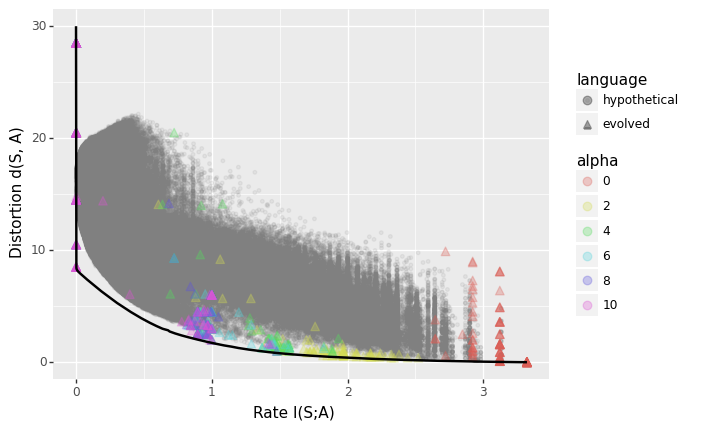

In [23]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=curve_data, mapping=pn.aes(x="rate", y="distortion")
    )  
    + pn.geom_point(  # sampled langs
        sampled_data,
        pn.aes(shape="language"),
        color="gray",
        size=1,
        alpha=0.1,
    )        
    + pn.geom_jitter( # simulation langs
        data=sim_data,
        mapping=pn.aes(
            color="alpha", 
            shape="language",
            ),
        alpha=0.3,
        # shape="o",
        size=3,
        # height=0.1,
    )
    + pn.geom_line(size=1) # pareto data last    
    + pn.xlab("Complexity $I(S;\hat{S})$")
    + pn.ylab("Communicative Cost D[S, \hat{S}]")
)
print(plot)

In [24]:
plot_save_dir = f"/Users/nathanielimel/lps/projects/rdsg/multirun/states=10/signals=10/similarity=nosofsky/distortion=squared_dist/dynamics={dynamic}/num_trials={num_trials}"
fn = plot_save_dir + "/multiple_alpha.png"
plot.save(filename=fn, width=10, height=10, dpi=300)

/Users/nathanielimel/miniforge3/envs/rdsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 10 in image.
/Users/nathanielimel/miniforge3/envs/rdsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/nathanielimel/lps/projects/rdsg/multirun/states=10/signals=10/similarity=nosofsky/distortion=squared_dist/dynamics=replicator_dynamic/num_trials=100/multiple_alpha.png
